# XGBoost

In [1]:
import pandas as pd
import numpy as np
import time, re, string
from sklearn.preprocessing import OneHotEncoder

from tqdm import tqdm_notebook as tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import hstack

## Load Train and Test Data with Derived Features

In [3]:
pd.options.display.max_columns = 100

train = pd.read_csv('input/train_featv3.csv')
test = pd.read_csv('input/test_featv3.csv')
train.head()

,user_id,is_open,is_click,date,month,hour,mins,communication_type,total_links,no_of_internal_links,no_of_images,no_of_sections,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_stopwords,mean_word_len,word_unique_percent,punct_percent,email_count_word,email_count_unique_word,email_count_letters,email_count_punctuations,email_cap_count,day_of_week,count_click,count_user,click_confidence,count_is_open,is_open_confidence,email_3_similar,sub_3_similar,campaign_id,sub_period,comm_type_click_percent,body_polarity,title_polarity,body_subjectivity,title_subjectivity
0,14051,0,0,1,9,19,55,3,88.0,79.0,13.0,4.0,1.0,12.0,12.0,88.0,5.0,2.0,6.416667,100.0,41.666667,238.0,159.0,1382.0,37.0,58.0,4,0.0,9.0,0.0,0.0,0.0,0.0,2.0,42,247,12.70333,0.278346,0.462500,0.644388,0.650000
1,134438,0,0,2,11,12,53,3,67.0,62.0,10.0,4.0,1.0,16.0,16.0,111.0,5.0,3.0,6.000000,100.0,31.250000,166.0,122.0,971.0,24.0,48.0,3,0.0,4.0,0.0,0.0,0.0,1.0,2.0,52,150,12.70333,0.071053,0.170455,0.376754,0.454545
2,181789,0,0,24,7,15,15,4,7.0,3.0,1.0,1.0,1.0,12.0,12.0,71.0,3.0,1.0,5.000000,100.0,25.000000,118.0,92.0,739.0,28.0,42.0,0,0.0,7.0,0.0,0.0,0.0,1.0,1.0,33,249,14.27746,0.408333,0.000000,0.579365,0.000000
3,231448,0,0,5,9,11,36,5,60.0,56.0,19.0,6.0,1.0,10.0,10.0,73.0,3.0,2.0,6.400000,100.0,30.000000,43.0,38.0,273.0,9.0,9.0,1,0.0,6.0,0.0,0.0,0.0,1.0,1.0,44,216,13.02976,0.166667,0.000000,0.766667,0.000000
4,185580,0,0,1,7,18,1,3,67.0,61.0,12.0,3.0,1.0,11.0,11.0,55.0,2.0,3.0,4.090909,100.0,18.181818,243.0,176.0,1498.0,37.0,35.0,5,0.0,5.0,0.0,0.0,0.0,0.0,1.0,29,220,12.70333,0.390083,0.000000,0.588671,0.000000


In [3]:
train.columns

Index(['user_id', 'is_open', 'is_click', 'date', 'month', 'hour', 'mins',
       'communication_type', 'total_links', 'no_of_internal_links',
       'no_of_images', 'no_of_sections', 'email_url', 'count_sent',
       'count_word', 'count_unique_word', 'count_letters',
       'count_punctuations', 'count_stopwords', 'mean_word_len',
       'word_unique_percent', 'punct_percent', 'email_count_word',
       'email_count_unique_word', 'email_count_letters',
       'email_count_punctuations', 'email_cap_count', 'day_of_week',
       'count_click', 'count_user', 'click_confidence', 'count_is_open',
       'is_open_confidence', 'body_polarity', 'title_polarity',
       'body_subjectivity', 'title_subjectivity', 'bkunal_jain', 'smeetups',
       'slive', 'shackathon', 'shire', 'swin', 'stop', 'user_mail_no'],
      dtype='object')

## Feature Engineering

- Date 
- Time (in minutes)
- Day of Week
- Communication Type
- Total Links
- No of Internal Links, No of Images
- Subject - Count of Sentences, Letters, Punctuations and Stopwords
- Subject - Unique Word Percentage
- Subject - Punctuation Percentage
- Email - Count of Word, Punctuation and Capital Letters
- Count Click
- Count User
- Click Confidence
- Count of People Opening the Mail
- Open Confidence
- Email Similarity, Subject Similarity
- Subscription Period
- Communication Type Click Percentage
- Count User Frequency
- Sentiment of Mail

In [4]:
train['time'] = train['hour']*60 + train['mins']
test['time'] = test['hour']*60 + test['mins']

In [5]:
### removed month ####

In [6]:
Y_train = train['is_click'].values

cols = ['user_id', 'date', 'time', 'communication_type', 'total_links',  
        'no_of_internal_links', 'no_of_images', 'count_sent', 'count_letters', 'count_punctuations', 
        'count_stopwords', 'word_unique_percent', 'punct_percent', 'email_count_word', 
        'email_count_unique_word', 'email_count_punctuations', 'email_cap_count', 'day_of_week', 
        'count_click', 'count_user', 'click_confidence','count_is_open','is_open_confidence',
        'body_polarity', 'title_polarity','body_subjectivity', 'title_subjectivity']


X_train = train[cols]
X_test = test[cols]

In [7]:
X_test.isnull().sum()

user_id                          0
date                             0
time                             0
communication_type               0
total_links                      0
no_of_internal_links             0
no_of_images                     0
count_sent                       0
count_letters                    0
count_punctuations               0
count_stopwords                  0
word_unique_percent              0
punct_percent                    0
email_count_word                 0
email_count_unique_word          0
email_count_punctuations         0
email_cap_count                  0
day_of_week                      0
count_click                      0
count_user                       0
click_confidence            151889
count_is_open                    0
is_open_confidence          151889
body_polarity                    0
title_polarity                   0
body_subjectivity                0
title_subjectivity               0
dtype: int64

### Fill NaN values with mean 

In [8]:
import warnings
warnings.filterwarnings('ignore')

## filled new user with click confidence of mean of first users ###
X_test['click_confidence'] = X_test['click_confidence'].fillna(0.0072169867589168555)
X_test['is_open_confidence'] = X_test['is_open_confidence'].fillna(0.10831444590242156)
X_test.loc[X_test['count_user'] == 0,'count_click'] = 0.0072169867589168555
X_test.loc[X_test['count_user'] == 0,'count_is_open'] = 0.10831444590242156
X_test.loc[X_test['count_user'] == 0,'count_user'] = 1

In [9]:
X_train.loc[:,'count_user_freq'] = (1/X_train.loc[:,'count_user'])
X_test.loc[:,'count_user_freq'] = (1/X_test.loc[:,'count_user'])

### Calculate Sentiment Score from Polarity and Subjectivity Scores

In [10]:
dropcols = ['body_polarity', 'title_polarity','body_subjectivity', 'title_subjectivity']
X_train.loc[:,'sentiment'] = X_train.loc[:,'body_polarity'] + X_train.loc[:,'title_polarity'] + X_train.loc[:,'body_subjectivity'] + X_train.loc[:,'title_subjectivity']
X_test.loc[:,'sentiment'] = X_test.loc[:,'body_polarity'] + X_test.loc[:,'title_polarity'] + X_test.loc[:,'body_subjectivity'] + X_test.loc[:,'title_subjectivity']
X_train.drop(dropcols,axis=1,inplace=True)
X_test.drop(dropcols,axis=1,inplace=True)

In [11]:
X_train.head()

,user_id,date,time,communication_type,total_links,no_of_internal_links,no_of_images,count_sent,count_letters,count_punctuations,count_stopwords,word_unique_percent,punct_percent,email_count_word,email_count_unique_word,email_count_punctuations,email_cap_count,day_of_week,count_click,count_user,click_confidence,count_is_open,is_open_confidence,count_user_freq,sentiment
0,14051,1,1195,3,88.0,79.0,13.0,1.0,88.0,5.0,2.0,100.0,41.666667,238.0,159.0,37.0,58.0,4,0.0,9.0,0.0,0.0,0.0,0.111111,2.035234
1,134438,2,773,3,67.0,62.0,10.0,1.0,111.0,5.0,3.0,100.0,31.250000,166.0,122.0,24.0,48.0,3,0.0,4.0,0.0,0.0,0.0,0.250000,1.072807
2,181789,24,915,4,7.0,3.0,1.0,1.0,71.0,3.0,1.0,100.0,25.000000,118.0,92.0,28.0,42.0,0,0.0,7.0,0.0,0.0,0.0,0.142857,0.987698
3,231448,5,696,5,60.0,56.0,19.0,1.0,73.0,3.0,2.0,100.0,30.000000,43.0,38.0,9.0,9.0,1,0.0,6.0,0.0,0.0,0.0,0.166667,0.933333
4,185580,1,1081,3,67.0,61.0,12.0,1.0,55.0,2.0,3.0,100.0,18.181818,243.0,176.0,37.0,35.0,5,0.0,5.0,0.0,0.0,0.0,0.200000,0.978753


In [12]:
X_test.isnull().sum()

user_id                     0
date                        0
time                        0
communication_type          0
total_links                 0
no_of_internal_links        0
no_of_images                0
count_sent                  0
count_letters               0
count_punctuations          0
count_stopwords             0
word_unique_percent         0
punct_percent               0
email_count_word            0
email_count_unique_word     0
email_count_punctuations    0
email_cap_count             0
day_of_week                 0
count_click                 0
count_user                  0
click_confidence            0
count_is_open               0
is_open_confidence          0
count_user_freq             0
sentiment                   0
dtype: int64

## Under Sampling using Repeated Edited Nearest Neighbour Algorithm

In [13]:
from imblearn.under_sampling import (AllKNN, EditedNearestNeighbours, RepeatedEditedNearestNeighbours)

print('RENN')
enn = RepeatedEditedNearestNeighbours(return_indices=True)
X_res, Y_res, idx_res = enn.fit_sample(X_train, Y_train)
reduction_str = ('Reduced {:.2f}%'.format(100 * (1 - float(len(X_res))/len(X_train))))
print(reduction_str)

RENN
Reduced 5.03%


In [14]:
print (X_res.shape, Y_res.shape)
print (Y_res.sum(), Y_train.sum())

(971719, 25) (971719,)
12782 12782


## Split Train-Validation Set

In [15]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import xgboost as xgb

X_rs_trn, X_rs_val, Y_res_trn, Y_res_val = train_test_split(X_res, Y_res, test_size=0.075, shuffle=True
                                                            , random_state=42)

print ("Train_shape: " + str(X_rs_trn.shape))
print ("Val_shape: " + str(X_rs_val.shape))
print ("No of positives in train: " + str(Y_res_trn.sum()))
print ("No of positives in val: " + str(Y_res_val.sum()))

Train_shape: (898840, 25)
Val_shape: (72879, 25)
No of positives in train: 11801
No of positives in val: 981


## Training the Model

In [17]:
params = {}
params['booster'] = 'gbtree'
params['objective'] = 'binary:logistic'
params['eta'] = 0.01
params['eval_metric'] = 'auc'
params['max_depth'] = 3
params['colsample_bytree'] = 0.8
params['subsample'] = 0.8
params['min_child_weight'] = 5
params['silent'] = 1

d_train = xgb.DMatrix(X_rs_trn, label=Y_res_trn)
d_valid = xgb.DMatrix(X_rs_val, label=Y_res_val)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]

print ('Training the model...')

# Third value is number of rounds (n_estimators), early_stopping_rounds stops training when it hasn't 
# improved for that number of rounds
clf = xgb.train(params, d_train, 7200, watchlist, early_stopping_rounds=50, verbose_eval=25)

# lb 6535 --> train-auc: 0.981083 valid-auc:0.979487 with Allknn maxdepth=5, min_child_weight=5, 0.8, 0.8
# lb 6597 --> train-auc:0.980757 valid-auc:0.978668 with RENN maxdepth=3, no min_child_weight, 0.8, 0.8
# lb 6641 --> train-auc:0.980614 valid-auc:0.978683 with RENN and polarity features sumed up: same params

Training the model...
[0]	train-auc:0.976375	valid-auc:0.974352
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[25]	train-auc:0.977767	valid-auc:0.975521
[50]	train-auc:0.977849	valid-auc:0.975642
[75]	train-auc:0.97831	valid-auc:0.976259
[100]	train-auc:0.978442	valid-auc:0.976497
[125]	train-auc:0.978556	valid-auc:0.976565
[150]	train-auc:0.978656	valid-auc:0.976641
[175]	train-auc:0.978786	valid-auc:0.976782
[200]	train-auc:0.978906	valid-auc:0.976918
[225]	train-auc:0.979034	valid-auc:0.977079
[250]	train-auc:0.979091	valid-auc:0.977161
[275]	train-auc:0.979157	valid-auc:0.977232
[300]	train-auc:0.97922	valid-auc:0.977296
[325]	train-auc:0.979287	valid-auc:0.977393
[350]	train-auc:0.97936	valid-auc:0.977513
[375]	train-auc:0.979404	valid-auc:0.977571
[400]	train-auc:0.979447	valid-auc:0.977648
[425]	train-auc:0.979482	valid-auc:0.977696
[450]	train-auc:0.979529	valid-auc:0.977778
[475]	t

### Plot Feature Importance

In [23]:
from operator import itemgetter

def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()

def get_importance(gbm, features):
    create_feature_map(features)
    importance = gbm.get_fscore(fmap='xgb.fmap')
    importance = sorted(importance.items(), key=itemgetter(1), reverse=True)
    return importance

print(get_importance(clf, list(X_train.columns.values)))

[('click_confidence', 1906), ('count_click', 1216), ('time', 1207), ('is_open_confidence', 808), ('user_id', 579), ('email_cap_count', 423), ('count_is_open', 377), ('count_user', 353), ('sentiment', 350), ('communication_type', 258), ('email_count_word', 223), ('email_count_unique_word', 201), ('no_of_images', 199), ('count_stopwords', 190), ('day_of_week', 182), ('punct_percent', 175), ('no_of_internal_links', 173), ('total_links', 169), ('word_unique_percent', 169), ('count_letters', 159), ('date', 146), ('email_count_punctuations', 119), ('count_punctuations', 99), ('count_user_freq', 72)]


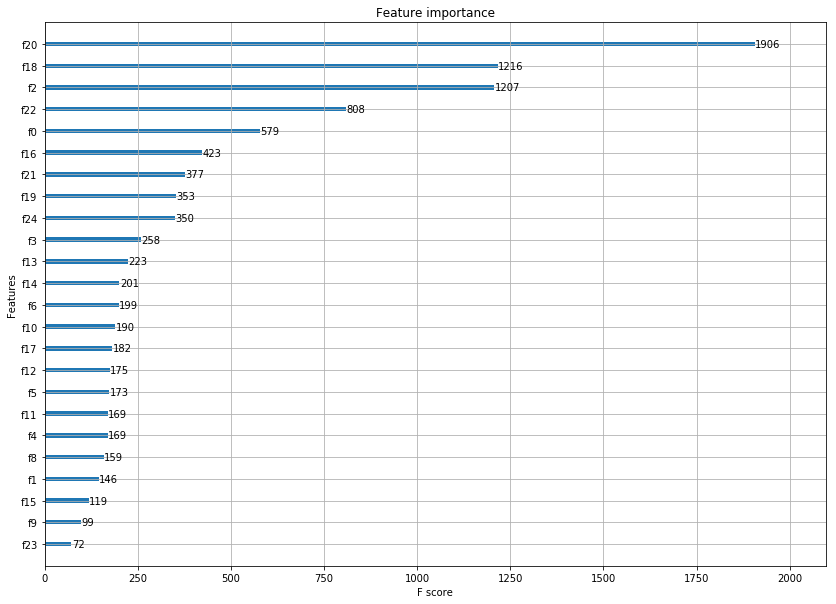

In [31]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(14, 10))
xgb.plot_importance(clf, ax=ax)

## Predicting on Test Data

In [32]:
d_test = xgb.DMatrix(X_test)
d_test.feature_names = d_train.feature_names

print ('Predicting...')
p_test = clf.predict(d_test) 

Predicting...


In [34]:
sub = pd.read_csv('input/sample_submission.csv')
sub['is_click'] = p_test
sub.head()

,id,is_click
0,63_122715,0.000002
1,56_76206,0.000002
2,57_96189,0.000004
3,56_166917,0.000002
4,56_172838,0.000003


In [36]:
sub.to_csv('sub_xgb.csv', index=False)

## Output Distribution

In [37]:
sub.describe()

,is_click
count,773858.000000
mean,0.013287
std,0.062110
min,0.000002
25%,0.000002
50%,0.000003
75%,0.000003
max,0.992902


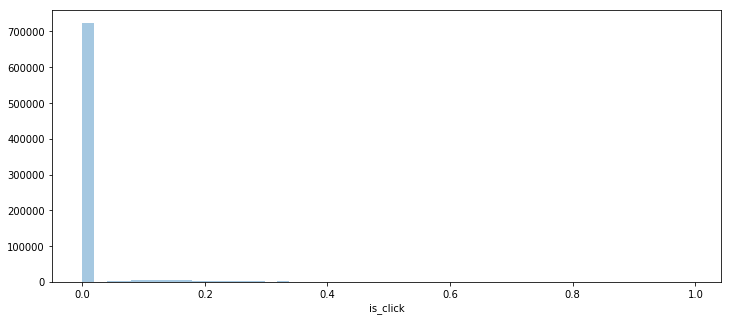

In [38]:
import seaborn as sns

plt.figure(figsize=(12, 5))
sns.distplot(sub['is_click'], kde = False)

## AV Leaderboard Score - 0.66823

## Final Solution is an ensemble of LightGBM and XGBoost
### Score - 0.68799

## Private LB - 0.68630